In [102]:
##### import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

In [121]:
##### random seeds
random_state = 10


##### graphs
nestimators = [250, 1250, 2250, 3250, 4250]
learningRate = [0.1, 0.01, 0.001, 0.0001, 0.00001]


##### models: hyperparameters (parameters were optimized after two rounds of selection)
##### random forest
n_estimators = [1550]
max_depth = [55]
max_features = ['auto'] #['auto', 2]
min_samples_leaf = [1] #[1, 2, 3]
oob_score = [True]
param_grid_rf = {'n_estimators': n_estimators,
                 'max_depth': max_depth,
                 'max_features': max_features,
                 'min_samples_leaf': min_samples_leaf,
                 'oob_score': oob_score}

##### decision tree
max_depth = [15] #[5, 10, 15, 20, 25]
max_features = ['auto']

param_grid_dt = {'max_depth': max_depth,
                 'max_features': max_features}

##### gradient boosting regression
n_estimators = [4250]
learning_rate = [0.01] #[0.00001, 0.0001, 0.001, 0.01, 0.1]
max_depth = [10]
subsample = [0.15]
max_features = ['auto']
param_grid_gbr = {'n_estimators': n_estimators,
                  'learning_rate': learning_rate,
                  'max_depth': max_depth,
                  'max_features': max_features,
                  'subsample': subsample}

##### ridge regression
alpha = [0.0, 10.0, 20.0, 40.0, 60.0, 80.0]
param_grid_ridge = {'alpha': alpha}

##### lasso regression
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
param_grid_lasso = {'alpha': alpha}

##### linear regression
param_grid_linear = {'fit_intercept': [True]}

In [105]:
def grid_search_cv(estimator, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator, param_grid, cv = 5, verbose = 2, n_jobs = -1)
    grid_search.fit(X_train, y_train)
    print('best parameters:', grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_ # , grid_search.cv_results_

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print('mae: {:0.6f}'.format(mae))
    print('mse: {:0.6f}'.format(mse))
    print('rmse: {:0.6f}'.format(rmse))
    print('r2: {:0.6f}'.format(r2))
    return mae, mse, rmse, r2


def regression_model(model, param_grid, X_train, X_test, y_train, y_test):
    best_grid = grid_search_cv(model, param_grid, X_train, y_train)
    print(best_grid[0])
    
    ##### evaluate the optimal model
    print('Train dataset:')
    train_result = evaluate(best_grid[0], X_train, y_train)
    print('Test dataset:')
    test_result = evaluate(best_grid[0], X_test, y_test)
    return best_grid, train_result, test_result

    
def permutation_importances(model, X, y, random_state):
    result = permutation_importance(model, X, y, n_repeats=10, random_state = random_state, n_jobs=-1)
    perm_sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots(figsize=(12,12))
    ax.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=X_test.columns[perm_sorted_idx])  
    ax.set_title('Permutation Importances')
    ax.set_xlabel('Score')
    plt.show()

In [81]:
##### dataset
modified = pd.read_csv("../data/modified_data.csv")
modified.head()

,image_id,street,city,city_code,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


In [82]:
##### copy dataset
data = modified.copy()

In [83]:
##### independent variables and dependent variable
y=np.log(data['price'])
X=data.drop(['image_id', 'street', 'city', 'price'], axis=1)

In [84]:
##### split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state)
#print(X_train.shape)
#print(X_test.shape)
#print(y_train.shape)
#print(y_test.shape)

In [85]:
##### standardize data
scaler = StandardScaler()
#scaler.fit(X_train)
#X_train_std = scaler.transform(X_train)
#X_test_std = scaler.transform(X_test)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [86]:
##### build models
model_rf, train_result_rf, test_result_rf = regression_model(RandomForestRegressor(random_state=random_state), param_grid_rf, X_train, X_test,  y_train, y_test)
model_dt, train_result_dt, test_result_dt = regression_model(DecisionTreeRegressor(random_state=random_state), param_grid_dt, X_train, X_test,  y_train, y_test)   
model_gbr, train_result_gbr, test_result_gbr = regression_model(GradientBoostingRegressor(random_state=random_state), param_grid_gbr, X_train, X_test,  y_train, y_test)
model_ridge, train_result_ridge, test_result_ridge = regression_model(Ridge(random_state=random_state), param_grid_ridge, X_train_std, X_test_std,  y_train, y_test)
model_lasso, train_result_lasso, test_result_lasso = regression_model(Lasso(random_state=random_state), param_grid_lasso, X_train_std, X_test_std,  y_train, y_test)
model_linear, train_result_linear, test_result_linear = regression_model(LinearRegression(), param_grid_linear, X_train_std, X_test_std, y_train, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


best parameters: {'max_depth': 55, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 1550, 'oob_score': True}
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=55, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1550, n_jobs=None, oob_score=True,
                      random_state=10, verbose=0, warm_start=False)
Train dataset:
mae: 0.073244
mse: 0.011550
rmse: 0.107471
r2: 0.955807
Test dataset:
mae: 0.191869
mse: 0.079206
rmse: 0.281435
r2: 0.692133
Fitting 5 folds for each of 1 candidates, totalling 5 fits
best parameters: {'max_depth': 15, 'max_features': 'auto'}
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   36.0s remaining:   54.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.2s finished


best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 4250, 'subsample': 0.15}
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls',
                          max_depth=10, max_features='auto',
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=4250, n_iter_no_change=None,
                          presort='deprecated', random_state=10, subsample=0.15,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)
Train dataset:
mae: 0.080699
mse: 0.011010
rmse: 0.104928
r2: 0.957873
Test dataset:
mae: 0.176747
mse: 0.064907
rmse: 0.254769
r2: 0.747710
Fitting 5 folds for each of 6 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


best parameters: {'alpha': 0.0}
Ridge(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=10, solver='auto', tol=0.001)
Train dataset:
mae: 0.331481
mse: 0.174569
rmse: 0.417815
r2: 0.332050
Test dataset:
mae: 0.323936
mse: 0.167257
rmse: 0.408971
r2: 0.349880
Fitting 5 folds for each of 6 candidates, totalling 30 fits
best parameters: {'alpha': 0.001}
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=10,
      selection='cyclic', tol=0.0001, warm_start=False)
Train dataset:
mae: 0.331419
mse: 0.174577
rmse: 0.417825
r2: 0.332019
Test dataset:
mae: 0.323854
mse: 0.167256
rmse: 0.408970
r2: 0.349885
Fitting 5 folds for each of 1 candidates, totalling 5 fits
best parameters: {'fit_intercept': True}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Train dataset:
mae: 0.331481
mse: 0.174569
rmse: 0.417815
r2: 0.332050
Test dataset:

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


mae: 0.122025
mse: 0.025563
rmse: 0.159886
r2: 0.902187
mae: 0.197794
mse: 0.076563
rmse: 0.276700
r2: 0.702404
mae: 0.230117
mse: 0.087445
rmse: 0.295711
r2: 0.665411
mae: 0.249487
mse: 0.104604
rmse: 0.323425
r2: 0.593412
mae: 0.360542
mse: 0.208021
rmse: 0.456093
r2: 0.204054
mae: 0.359178
mse: 0.208286
rmse: 0.456384
r2: 0.190403
mae: 0.399166
mse: 0.254938
rmse: 0.504914
r2: 0.024536
mae: 0.396033
mse: 0.251870
rmse: 0.501866
r2: 0.020997
mae: 0.403605
mse: 0.260697
rmse: 0.510585
r2: 0.002502
mae: 0.400352
mse: 0.257273
rmse: 0.507221
r2: -0.000006
mae: 0.040944
mse: 0.003152
rmse: 0.056141
r2: 0.987940
mae: 0.189555
mse: 0.080391
rmse: 0.283533
r2: 0.687525
mae: 0.142203
mse: 0.035183
rmse: 0.187571
r2: 0.865381
mae: 0.191552
mse: 0.069821
rmse: 0.264236
r2: 0.728611
mae: 0.271226
mse: 0.119192
rmse: 0.345242
r2: 0.543939
mae: 0.281610
mse: 0.129776
rmse: 0.360244
r2: 0.495569
mae: 0.380771
mse: 0.231891
rmse: 0.481551
r2: 0.112721
mae: 0.378303
mse: 0.230395
rmse: 0.479995
r2: 

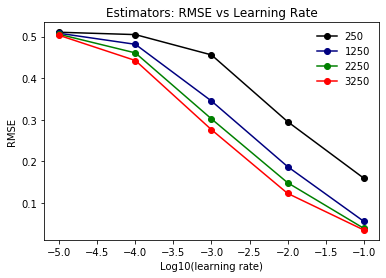

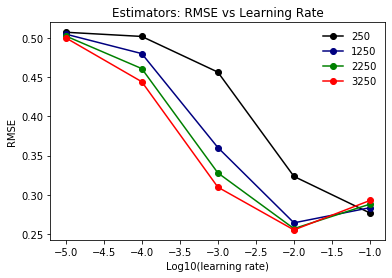

In [123]:
##### graphs
RMSE=[]
RMSEt =[]
for est in nestimators:
    temp=[]
    tempt=[]
    for rate in learningRate:
        m = GradientBoostingRegressor(n_estimators = est,
                                      learning_rate = rate,
                                      max_depth = model_gbr[1]['max_depth'],
                                      max_features = model_gbr[1]['max_features'],
                                      subsample = model_gbr[1]['subsample'],
                                      random_state = random_state)
        m.fit(X_train, y_train)
        r = evaluate(m, X_train, y_train)
        rt = evaluate(m, X_test, y_test)
        temp.append(r[2])
        tempt.append(rt[2])            
    RMSE.append(temp)
    RMSEt.append(tempt)
    
fig, ax = plt.subplots(figsize=(6,4)) ### train model
ax.plot(np.log10(learningRate), RMSE[0], color='black', marker='o')
ax.plot(np.log10(learningRate), RMSE[1], color='navy', marker='o')
ax.plot(np.log10(learningRate), RMSE[2], color='green', marker='o')
ax.plot(np.log10(learningRate), RMSE[3], color='red', marker='o')
ax.set_title('Estimators: RMSE vs Learning Rate')
ax.set_xlabel('Log10(learning rate)')
ax.set_ylabel('RMSE')
ax.legend(nestimators, frameon=False)
plt.show()

fig, ax = plt.subplots(figsize=(6,4)) ### test model
ax.plot(np.log10(learningRate), RMSEt[0], color='black', marker='o')
ax.plot(np.log10(learningRate), RMSEt[1], color='navy', marker='o')
ax.plot(np.log10(learningRate), RMSEt[2], color='green', marker='o')
ax.plot(np.log10(learningRate), RMSEt[3], color='red', marker='o')
ax.set_title('Estimators: RMSE vs Learning Rate')
ax.set_xlabel('Log10(learning rate)')
ax.set_ylabel('RMSE')
ax.legend(nestimators, frameon=False)
plt.show()

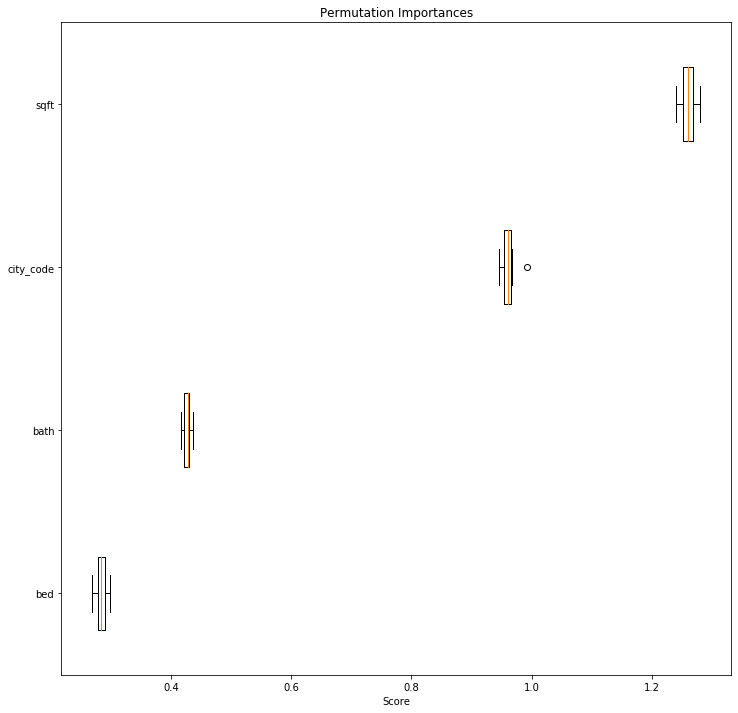

In [111]:
##### permutation importances
estimator_rmse = [train_result_rf[2], train_result_dt[2], train_result_gbr[2], train_result_ridge[2], train_result_lasso[2], train_result_linear[2]]
model = [model_rf[0], model_dt[0], model_dt[0], model_ridge[0], model_lasso[0], model_linear[0]]

value = 10
for i in range(len(estimator_rmse)):
    if abs(estimator_rmse[i]) < value:
        value = estimator_rmse[i]
        index = i

if estimator_rmse[index] in [train_result_rf[2], train_result_dt[2], train_result_gbr[2]]:
    permutation_importances(model[index], X_train, y_train, random_state)
else:
    permutation_importances(model[index], X_train_std, y_train, random_state)

In [95]:
##### result table
output_train = [train_result_rf, train_result_dt, train_result_gbr, train_result_ridge, train_result_lasso, train_result_linear]
output_test = [test_result_rf, test_result_dt, test_result_gbr, test_result_ridge, test_result_lasso, test_result_linear]
train_table = pd.DataFrame(data = output_train, index = ['Random Forest', 'Decision Tree', 'Gradient Boosting Regression', 'Ridge Regression', 'Lasso Regression', 'Linear Regression'], columns = ['MAE', 'MSE', 'RMSE', 'R2'])
test_table = pd.DataFrame(data = output_test, index = ['Random Forest', 'Decision Tree', 'Gradient Boosting Regression', 'Ridge Regression', 'Lasso Regression', 'Linear Regression'], columns = ['MAE', 'MSE', 'RMSE', 'R2'])

In [117]:
print(train_table)
print()
print(test_table)

                                   MAE       MSE      RMSE        R2
Random Forest                 0.073244  0.011550  0.107471  0.955807
Decision Tree                 0.111343  0.038515  0.196251  0.852633
Gradient Boosting Regression  0.080699  0.011010  0.104928  0.957873
Ridge Regression              0.331481  0.174569  0.417815  0.332050
Lasso Regression              0.331419  0.174577  0.417825  0.332019
Linear Regression             0.331481  0.174569  0.417815  0.332050

                                   MAE       MSE      RMSE        R2
Random Forest                 0.191869  0.079206  0.281435  0.692133
Decision Tree                 0.242172  0.129554  0.359936  0.496431
Gradient Boosting Regression  0.176747  0.064907  0.254769  0.747710
Ridge Regression              0.323936  0.167257  0.408971  0.349880
Lasso Regression              0.323854  0.167256  0.408970  0.349885
Linear Regression             0.323936  0.167257  0.408971  0.349880
